In [0]:
# colab setting
!pip install GraphRicciCurvature
!pip install grakel

import networkx as nx
import numpy as np
import math
import importlib
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import pandas as pd

from tqdm import tqdm_notebook

# matplotlib setting
%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
clear_output()

In [0]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric
clear_output()

# CurvConv architecture

In [0]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Sequential as seq, Parameter,LeakyReLU,init,Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax, degree, add_self_loops, remove_self_loops
from torch_geometric.nn import GCNConv, EdgeConv, ECConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_=torch.manual_seed(42)

In [0]:
class curvGN(MessagePassing):
    def __init__(self, in_channels, out_channels, w_mul=None, bias=True):
        super(curvGN, self).__init__(aggr='add')
        # self.w_mul = w_mul
        self.lin = Linear(in_channels, out_channels)
        widths = [1, out_channels]
        self.w_mlp_out = create_wmlp(widths, out_channels, True)

    def forward(self, x, edge_index, w_mul):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        out_weight = self.w_mlp_out(w_mul)
        out_weight = softmax(out_weight, edge_index[0])
        return self.propagate(edge_index,  x=x, out_weight=out_weight), out_weight

    def message(self, x_j, out_weight):
        return out_weight*x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 5: Return new node embeddings.
        return aggr_out

def create_wmlp(widths, nfeato, lbias):
    mlp_modules=[]
    for k in range(len(widths)-1):
        mlp_modules.append(Linear(widths[k], widths[k+1], bias=False))
        mlp_modules.append(LeakyReLU(0.2, True))
    mlp_modules.append(Linear(widths[len(widths)-1], nfeato, bias=lbias))

    return seq(*mlp_modules)


In [0]:
class NetСurv(torch.nn.Module):
    def __init__(self, num_features, num_classes, w_mul=None, hidden=64):
        '''
        w_mul - curvatures
        '''
        super(NetСurv, self).__init__()

        self.conv1 = curvGN(num_features, hidden, w_mul=w_mul)
        self.conv2 = curvGN(hidden, num_classes, w_mul=w_mul)

    def forward(self, data, w_mul):
        x, edge_index = data.x, data.edge_index

        x, _ = self.conv1(x, edge_index, w_mul)
        x = F.elu(x)
        x = F.dropout(x,training=self.training)
        x, _ = self.conv2(x, edge_index, w_mul)
        
        return F.log_softmax(x, dim=1)

class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=64):
        super(Net, self).__init__()

        self.conv1 = GCNConv(num_features, hidden)
        self.conv2 = GCNConv(hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    

In [0]:
def get_curvatures_tensor(data, ricci_curvatures, self_loops=True):

    if isinstance(ricci_curvatures, dict):
        ricci_curvatures_tensor = torch.zeros((data.num_edges + data.num_nodes if \
                                              self_loops else data.num_edges,), dtype=torch.float).to(device)
        for i in range(data.num_edges):
            edge = data.edge_index[:,i].tolist()
            if tuple(edge) in ricci_curvatures:
                ricci = ricci_curvatures[tuple(edge)]
            elif self_loops:
                ricci = 0.0
            else:
                raise RuntimeError    
            ricci_curvatures_tensor[i] = ricci
    elif isinstance(ricci_curvatures, list):
        ricci_curvatures_tensor = torch.tensor(ricci_curvatures, dtype=torch.float).to(device)
    else:
        raise TypeError('Wrong `ricci_curvatures` type, only list and dict are supported!')    
    return ricci_curvatures_tensor      

In [0]:
# from http://www3.cs.stonybrook.edu/~chni/
def FormannCurvature(G, weighted=False, EPS=1e-15):
    G = G.copy()
    for (v1, v2) in G.edges():
        if not weighted:
            if G.is_directed():
                v1_nbr = set(list(G.predecessors(v1)) + list(G.successors(v1)))
                v2_nbr = set(list(G.predecessors(v2)) + list(G.successors(v2)))
            else:
                v1_nbr = set(G.neighbors(v1))
                v1_nbr.remove(v2)
                v2_nbr = set(G.neighbors(v2))
                v2_nbr.remove(v1)
            face = v1_nbr & v2_nbr
            prl_nbr = (v1_nbr | v2_nbr) - face
            G[v1][v2]["formanCurvature"] = len(face) + 2 - len(prl_nbr)
        else:
            w_e = G[v1][v2]['weight'] + np.sqrt(EPS)
            w_i = 1.
            w_j = 1.
            S_i = sum([w_i/np.sqrt(v['weight']*w_e + EPS) if k!=v2 else 0. \
                       for k,v in G[v1].items()])
            S_j = sum([w_j/np.sqrt(v['weight']*w_e + EPS) if k!=v1 else 0. \
                      for k,v in G[v2].items()])
            curv = w_e*( (w_i/w_e) + (w_j/w_e) - S_i - S_j)
            G[v1][v2]["formanCurvature"] = curv
            assert not np.isnan(curv).any()

    # Node Forman curvature
    for n in G.nodes():
        fcsum = 0  # sum of the neighbor Forman curvature
        if G.degree(n) != 0:
            for nbr in G.neighbors(n):
                if 'formanCurvature' in G[n][nbr]:
                    fcsum += G[n][nbr]['formanCurvature']
            # assign the node Forman curvature to be the average of node's adjacency edges
            G.nodes[n]['formanCurvature'] = fcsum / G.degree(n)
    print("Forman curvature computation done.")   
                
    return G

# Compare performance 

In [0]:
# import time 
# n_edges = []
# times_olliver = []
# times_formann = []

# for n_nodes in tqdm_notebook(np.arange(2,30)):
    
#     complete_graph = nx.complete_graph(n_nodes) 
#     n_edges.append(complete_graph.number_of_edges())
    
#     t1=time.time()
#     orc = OllivierRicci(complete_graph, alpha=0.5, verbose="ERROR")
#     _ = orc.compute_ricci_curvature()
#     t2=time.time()
#     times_olliver.append(t2-t1)

#     t1=time.time()
#     _=FormannCurvature(complete_graph)
#     t2=time.time()
#     times_formann.append(t2-t1)

# clear_output()    

# plt.figure(dpi=100)
# plt.plot(n_edges,times_olliver, label='Olliver-Ricci')
# plt.plot(n_edges,times_formann, label='Formann-Ricci')
# plt.xlabel('# edges in graph')
# plt.ylabel('time, sec.')
# plt.legend()
# plt.show()


# Nodes classification

## Dataset

In [0]:
from torch_geometric.datasets import Planetoid, Amazon, Coauthor
from torch_geometric.utils.convert import from_networkx, to_networkx

datasets = {
            'Amazon-Computer' : Amazon(root='/tmp/Amazon', name='Computers'),
            'Cora':Planetoid(root='/tmp/Cora',  name='Cora'),
            'CiteSeer':Planetoid(root='/tmp/CiteSeer', name='CiteSeer'),
            'PubMed':Planetoid(root='/tmp/PubMed', name='PubMed'),
}

dataset = datasets['CiteSeer']
num_features = dataset.num_features
num_classes = dataset.num_classes

data = dataset[0]
num_nodes = data.num_nodes
# data.edge_index, _ = add_self_loops(data.edge_index, num_nodes=num_nodes)
assert hasattr(data, 'test_mask') or hasattr(data, 'train_mask')
data_nx = to_networkx(data,  node_attrs='x')
     

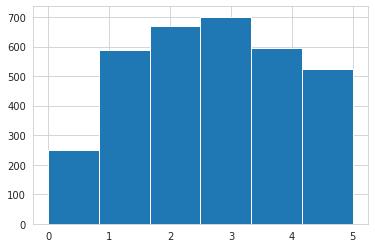

In [64]:
targets = data.y.numpy()
plt.hist(targets,bins=len(np.unique(targets)))
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
f1_metric = lambda y1, y2: f1_score(y1,y2, average='weighted')

models = {'KNN Classifier':KNeighborsClassifier,
          'Random Forest':RandomForestClassifier,
          'Log Regression':LogisticRegression}

def train_val_clf(models, data=None, X=None, y=None, metric=f1_metric):
    if data is not None:
        X_train = data.x[data.train_mask]
        y_train = data.y[data.train_mask]
        X_test = data.x[data.test_mask]
        y_test = data.y[data.test_mask]
    else:
        (X_train, 
        X_test, 
        y_train, 
        y_test) = train_test_split(X, y, test_size=0.33, random_state=42)
  
    results = {}
    for k,v in models.items():
        est = v()
        est.fit(X_train, y_train)
        results[k] = metric(y_test,est.predict(X_test))
    return results

results_nodes = train_val_clf(models, data)

In [66]:
results_nodes

{'KNN Classifier': 0.2923477514840837,
 'Log Regression': 0.6037277077428737,
 'Random Forest': 0.593858137452438}

In [67]:
edge_weight_types = ['one', 'euclidean', 'manhattan']
edge_weight_type = 'manhattan'

for edge in tqdm_notebook(data_nx.edges):
    if edge_weight_type == 'one':
        data_nx[edge[0]][edge[1]]['weight'] = 1.
    elif edge_weight_type == 'euclidean': 
        data_nx[edge[0]][edge[1]]['weight'] = torch.norm(torch.tensor(data_nx.nodes[edge[0]]['x']) -\
                                                         torch.tensor(data_nx.nodes[edge[1]]['x']), p=2 )
    elif edge_weight_type == 'manhattan': 
        data_nx[edge[0]][edge[1]]['weight'] = torch.norm(torch.tensor(data_nx.nodes[edge[0]]['x']) - \
                                                         torch.tensor(data_nx.nodes[edge[1]]['x']), p=1)  
    else:
      raise KeyError('Wrong `edge_weight_type`')   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Compute Olliver-Ricci: Yes
Forman curvature computation done.


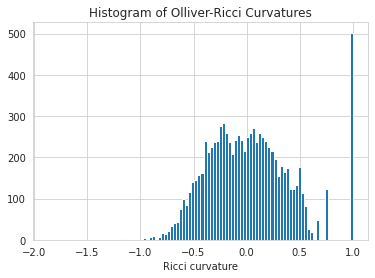

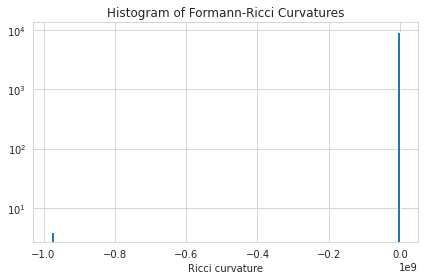

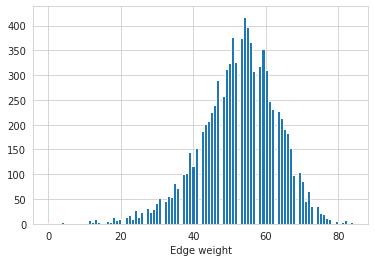

In [68]:
compute_olliver_ricci = data.edge_index.shape[1] < 20*1e3
weighted_edges = edge_weight_type != 'one'
learn_curv_edges = False
from collections import Counter
nbr_topk = max(Counter(data.edge_index[0].tolist()).values())

print('Compute Olliver-Ricci:', 'Yes' if compute_olliver_ricci else 'No')

if compute_olliver_ricci:
    orc = OllivierRicci(data_nx, alpha=0.5, verbose="ERROR", nbr_topk=nbr_topk)
    _ = orc.compute_ricci_curvature()
    G_orc = orc.G.copy()
    ricci_curvatures_olliver = nx.get_edge_attributes(G_orc, "ricciCurvature")
    ricci_curvatures_olliver_nodes = [(G_orc.nodes[i]['ricciCurvature'] if hasattr(G_orc.nodes[i],'ricciCurvature') else 1e-15) for i in range(num_nodes)]
    #nx.get_node_attributes(G_orc, 'ricciCurvature')
    # plot
    plt.figure()
    plt.hist(ricci_curvatures_olliver.values(),bins=100)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Olliver-Ricci Curvatures")

G_frc = FormannCurvature(data_nx, weighted=weighted_edges)
ricci_curvatures_formann = nx.get_edge_attributes(G_frc, 'formanCurvature')
ricci_curvatures_formann_nodes = [G_frc.nodes[i]['formanCurvature'] if hasattr(G_frc.nodes[i], 'formanCurvature') else 1e-15 for i in range(num_nodes)] 
#nx.get_node_attributes(G_frc, 'formanCurvature')
# plot
plt.figure()
plt.yscale('log')
plt.hist(ricci_curvatures_formann.values(),bins=100)
plt.xlabel('Ricci curvature')
plt.title("Histogram of Formann-Ricci Curvatures")
plt.tight_layout()

edges_weights =  nx.get_edge_attributes(data_nx, "weight")
# plot
plt.figure()
plt.hist(edges_weights.values(),bins=100)
plt.xlabel('Edge weight')
plt.show()

In [0]:
data_curv_formann = data.clone()
data_curv_olliver = data.clone()

data_curv_olliver.x = torch.cat([data_curv_olliver.x, 
                                torch.tensor(ricci_curvatures_olliver_nodes, dtype=torch.float32).unsqueeze(1)],1)

data_curv_formann.x = torch.cat([data_curv_formann.x, 
                                torch.tensor(ricci_curvatures_formann_nodes, dtype=torch.float32).unsqueeze(1)],1)

results_nodes_curv_olliver = train_val_clf(models, data_curv_olliver)
results_nodes_curv_forman = train_val_clf(models, data_curv_formann)

In [70]:
df = pd.DataFrame(columns=results_nodes.keys(), 
             index=['Only node features', 'Node features + Olliver Curv', 'Node features + Formann Curv'],
             data=np.array([list(results_nodes.values()),
                        list(results_nodes_curv_olliver.values()),
                        list(results_nodes_curv_forman.values())]))
df

,KNN Classifier,Random Forest,Log Regression
Only node features,0.292348,0.593858,0.603728
Node features + Olliver Curv,0.292348,0.580824,0.603728
Node features + Formann Curv,0.292348,0.562157,0.603728


## Training

In [0]:
def train_model(model, 
                data, 
                ricci_curvatures_tensor=None, 
                use_ricci_curvature=False,
                n_epochs=150):

    data = data.clone().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    loss_history = []
    acc_history = []
    for epoch in tqdm_notebook(range(n_epochs)):
        
        model.train()
        optimizer.zero_grad()
        if use_ricci_curvature:
            out = model(data, ricci_curvatures_tensor)
        else:  
            out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        model.eval()
        pred = out
        _, pred = pred.max(dim=1)
        y_pred = pred[data.test_mask].detach().cpu().numpy()
        y_true = data.y[data.test_mask].detach().cpu().numpy()
        # correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = f1_metric(y_true, y_pred)
        # acc = correct / data.test_mask.sum().item()
        acc_history.append(acc)

    return loss_history, acc_history

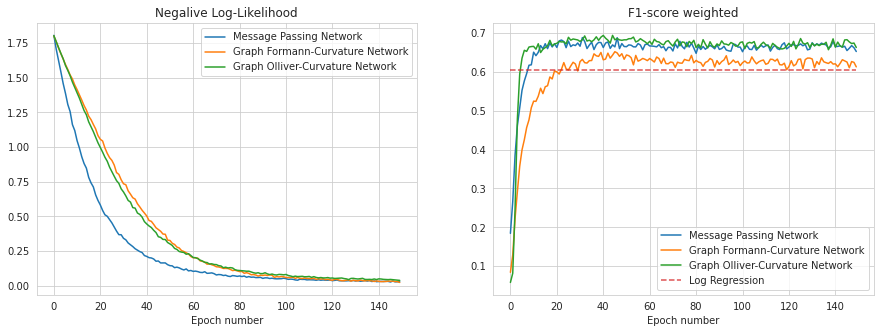

In [72]:
#################
# DEFINE MODELS #
#################
ricci_curvatures_formann_tensor = get_curvatures_tensor(data, ricci_curvatures_formann).unsqueeze(1)

if compute_olliver_ricci:
    ricci_curvatures_olliver_tensor = get_curvatures_tensor(data, ricci_curvatures_olliver).unsqueeze(1)
if weighted_edges:
    edges_weights_tensor = get_curvatures_tensor(data, edges_weights).unsqueeze(1)

# edges-weights
if weighted_edges:
    model_curv_edges = NetСurv(num_features, num_classes).to(device)
    out = model_curv_edges(data.to(device), edges_weights_tensor)

# oliver-ricci
if compute_olliver_ricci:
    model_curv_olliver = NetСurv(num_features, num_classes).to(device)
    out = model_curv_olliver(data.to(device), ricci_curvatures_olliver_tensor)

# formann-ricci
model_curv_formann = NetСurv(num_features, num_classes).to(device)
out = model_curv_formann(data.to(device), ricci_curvatures_formann_tensor)

# zero curvatures
model_curv_zeros = NetСurv(num_features, num_classes).to(device)
zeros_curvatures = torch.zeros_like(ricci_curvatures_formann_tensor)
out = model_curv_zeros(data.to(device), zeros_curvatures)

# message-passing
model = Net(num_features, num_classes).to(device)
out = model(data.to(device))


assert(not torch.isnan(ricci_curvatures_formann_tensor).any().item() and 
       not torch.isnan(ricci_curvatures_olliver_tensor).any().item())

################
# TRAIN MODELS #
################
loss_hist, acc_history = train_model(model, data, use_ricci_curvature=False)
loss_hist_curv_forman, acc_history_curv_formann = train_model(model_curv_formann,
                                                              data, 
                                                              ricci_curvatures_formann_tensor, 
                                                              use_ricci_curvature=True)
if compute_olliver_ricci:
    loss_hist_curv_olliver, acc_history_curv_olliver = train_model(model_curv_olliver, 
                                                                    data, 
                                                                    ricci_curvatures_olliver_tensor, 
                                                                    use_ricci_curvature=True)
loss_hist_curv_zeros, acc_history_curv_zeros = train_model(model_curv_zeros,
                                                          data, 
                                                          zeros_curvatures,
                                                          use_ricci_curvature=True)
if weighted_edges and learn_curv_edges:
    loss_hist_curv_edges, acc_history_curv_edges = train_model(model_curv_edges,
                                                              data, 
                                                              edges_weights_tensor,
                                                              use_ricci_curvature=True)

clear_output()


################
# PLOT RESULTS #
################
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(loss_hist, label = 'Message Passing Network')
ax1.plot(loss_hist_curv_forman, label = 'Graph Formann-Curvature Network')
if compute_olliver_ricci:
    ax1.plot(loss_hist_curv_olliver, label = 'Graph Olliver-Curvature Network')
# ax1.plot(loss_hist_curv_zeros, label = 'Graph ZERO-CURVATURE Network')
if weighted_edges and learn_curv_edges:
    ax1.plot(loss_hist_curv_edges, label = 'Graph Edge-Weight-Curv Network')


ax2.plot(acc_history, label = 'Message Passing Network')
ax2.plot(acc_history_curv_formann, label = 'Graph Formann-Curvature Network')
if compute_olliver_ricci:
    ax2.plot(acc_history_curv_olliver, label = 'Graph Olliver-Curvature Network')
# ax2.plot(acc_history_curv_zeros, label = 'Graph ZERO-CURVATURE Network')
if weighted_edges and learn_curv_edges:
    ax2.plot(acc_history_curv_edges, label = 'Graph Edge-Weight-Curv Network')

marks = ['--', '.', '^']
for i,(k,acc) in enumerate(results_nodes.items()):
    if k == 'Log Regression':
        ax2.plot([acc]*len(acc_history),'--',label=k, alpha=0.8, markersize=1)

ax1.legend()
ax2.legend()

ax1.set_title('Negalive Log-Likelihood')
ax2.set_title('F1-score weighted')
ax1.set_xlabel('Epoch number')
ax2.set_xlabel('Epoch number')

plt.show()

# Graph classification

In [105]:
import grakel
from grakel import GraphKernel
from grakel.kernels import VertexHistogram, ShortestPath, WeisfeilerLehman
from grakel.datasets import fetch_dataset

mutag = fetch_dataset("MUTAG", verbose=False, as_graphs=False)
mutag_G = fetch_dataset("MUTAG", verbose=False, as_graphs=True)
X_mutag, y_mutag = mutag.data, mutag.target
y_mutag.shape

(188,)

In [0]:
# intitalize Weisfeiler-Lehman kernel with Vertex histogram as the base kernel
wl_kernel = WeisfeilerLehman(n_iter=10, normalize=True, base_graph_kernel=VertexHistogram)
# compute Weisfeiler-Lehman kernel
K = wl_kernel.fit_transform(X_mutag)

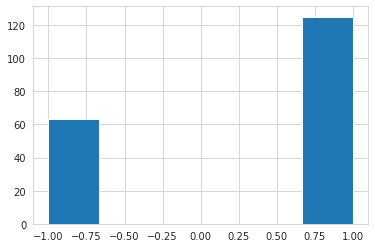

In [75]:
plt.hist(y_mutag,bins=len(np.unique(targets)))
plt.show()

In [76]:
from sklearn.model_selection import train_test_split
train_val_clf(models, data=None, X=K, y=y_mutag, metric=f1_metric)

{'KNN Classifier': 0.8903252835383189,
 'Log Regression': 0.771462706946578,
 'Random Forest': 0.8044296788482835}

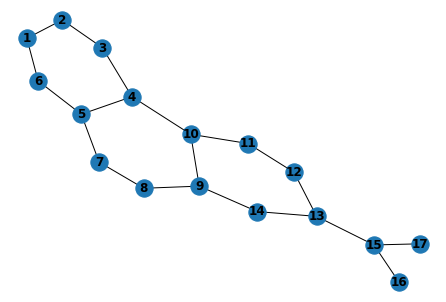

In [131]:
X_mutag_nx = []
for (edges, nodes, edges_labels) in X_mutag: 
    g = nx.Graph()
    g.add_edges_from(edges)
    X_mutag_nx.append(g)
nx.draw(X_mutag_nx[0], with_labels=True, font_weight='bold')